A function to process the user input for both online and offline modes and returns a df of that file

In [20]:
def read_chat_input_file(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    return data

counting stopwords in each row of text column


In [21]:
def count_stopwords(question):
    # Tokenize the text
    tokens = word_tokenize(question)
    stop_words = set(stopwords.words('english'))
    # Count the number of stopwords
    stopwords_count = sum(1 for word in tokens if word.lower() in stop_words)
    return stopwords_count

counting all words in each row of text column

In [22]:
def count_words(question):
    tokens = word_tokenize(question)
    return len(tokens)

a function to perform EDA on my custom question dataset

In [23]:
def perform_eda(file_path):
    # checking for missing values in our df
    df = read_chat_input_file(file_path)
    print("amount of missing values is: ",df.isna().sum())
    # checking basic info about the df
    print(df.shape)
    #print("columns are:", df.columns)
    
    #printing text length in each row of our target column
    df['text_length'] = df.question.apply(len)
    print(df['text_length'].head())
    
    #distribution of question text length distribution in histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    df['text_length'].hist(bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of question Length')
    plt.xlabel('Length of question')
    plt.ylabel('Count of questions')
    plt.show()
    
    #distribution of my target column in bar plot
    class_counts = df['intent'].value_counts()
    print(class_counts)
    class_counts.plot(kind='bar')
    plt.title("Intent Classes Distribution")
    plt.xlabel('class (1,book_flight, 2,change_flight, 3,cancel flight, 4,unknown)' )
    plt.ylabel('count of each')
    plt.xticks(rotation=0)
    plt.show()
    
    # Total stopwords in each row of our target column
    stopwords_total_amount = df['question'].apply(count_stopwords)
    print("Total stop words in each row:\n", stopwords_total_amount)
    
    # All words count in each row of our target column
    words_total_amount = df['question'].apply(count_words)
    print("Total words in each row:\n", words_total_amount)

chat answer function - it checks what is the next state and writes the corresponding output to the user and returning it

In [24]:
def answer_question(next_state, customer_name):
    #initializing output
    output = ''
    # a set of conditions to give the correct output based on the next state of the state machine
    if next_state == 5 or next_state == 6 or next_state == 7:
        output = customer_name + ", Thank you, i have performed what you asked! Is there anything else i can help you with today?"
    elif next_state == 1:
        output = customer_name + ", where would you like to fly"
    elif next_state == 2:
        output = customer_name + ", enter your new destination"
    elif next_state == 3:
        output = customer_name + ", enter reason for cancelling"
    elif next_state == 4:
        output = customer_name + ", enter dates you want for your flight. Write only in this format: 'Monthname', 'year.' Example: January 1, 2023"
    elif next_state == 0:
        output = customer_name + ", Sorry, I did not understand, i can only help with booking, changing or cancelling flight, Please try again"
        
    return output

a function to determine the next_state

In [25]:
def find_next_state(intent, current_state, entities):
    # a set of conditions to figure out what is the next state in the state machine based on the current state and the predicted user intent
    if current_state == 7 or current_state == 6 or current_state == 5:
        current_state = 0
        return find_next_state(intent, current_state, entities)  # Add return here
    elif (current_state == 0 or current_state == 7) and intent == 'book_flight':
        current_state = 1
    elif (current_state == 0 or current_state == 5) and intent == 'change_flight':
        current_state = 2
    elif (current_state == 0 or current_state == 6) and intent == 'cancel_flight':
        current_state = 3
    elif current_state == 0 and intent == 'unknown':
        current_state = 0 
    elif current_state == 1:
        # here we check the user input to make sure he entered a destination
        if check_if_entity_is_in_user_input(entities, 'GPE'):
            current_state = 4
        else:
            current_state = 1
    elif current_state == 4:
        # here we check the user input to make sure he entered a correct formatted date
        if check_if_entity_is_in_user_input(entities, 'DATE'):
            current_state = 7
        else:
            current_state = 4
    elif current_state == 2:
        # here we check the user input to make sure he entered a destination
        if check_if_entity_is_in_user_input(entities, 'GPE'):
            current_state = 5
        else:
            current_state = 2
    elif current_state == 3:
        current_state = 6
    elif current_state == 0 and intent == 'unknown':
        current_state = 0
    return current_state  # Return current_state at the end

a function to find the entities in a question and returning them

In [26]:
def find_entities(user_input):
    # Load SpaCy's English model
    nlp = spacy.load("en_core_web_sm")
    # Process the input text to extract named entities
    doc = nlp(user_input)
    # Initialize an empty list to store the extracted entities
    entities = []
    # Iterate over the named entities in the processed document
    for ent in doc.ents:
        # Create a string representation of the named entity, including its text and label
        entity_string = f"{ent.text} ({ent.label_})"
        # Append the entity string to the list of entities
        entities.append(entity_string)
    # Return the list of extracted entities
    return entities

a function to turn user question into a df my existing model can work with

In [27]:
def transform_question(question_string):
    # Create a DataFrame with the question column from user question string
    df = pd.DataFrame({'question': [question_string]})
    return df

a function to find the polarity and sentiment of a question

In [28]:
def find_sentiment(user_input):
    # Load SpaCy with English model
    nlp = spacy.load("en_core_web_sm")
    # Add spacytextblob to the pipeline
    nlp.add_pipe('spacytextblob')
    # Process the text
    doc = nlp(user_input)
    # Get the sentiment of the text
    sentiment = doc._.blob.sentiment
    # returning polarity and sentiment
    return sentiment

A function to create my own data set with given intents to train my model on

In [29]:
def create_question_dataset():
    # creating a question data set for model training and classification
    question_dataset = [
        ["Can you help me find flights to Paris?", "book_flight"],
        ["What are the cheapest flights to Barcelona departing next week?", "book_flight"],
        ["I need to fly round trip from Tel Aviv to Berlin on the 24/12/24?", "book_flight"],
        ["Do you have any non-stop flights from Rome to Budapest?", "book_flight"],
        ["What airlines fly from London to Tel Aviv?", "book_flight"],
        ["Can you find me  a morning flight from Dubai to New York?", "book_flight"],
        ["Can you find flights with a maximum layover of 2 hours?", "book_flight"],
        ["I need a return flight from Tokyo on the 19/6/24, what are my options?", "book_flight"],
        ["Are there any deals on flights to Bucharest departing in June?", "book_flight"],
        ["Can you find me a flight that arrives in Pakistan before noon?", "book_flight"],
        ["What's the cheapest way to get to Israel this weekend?", "book_flight"],
        ["Do you have any red-eye flights departing for Belgium tonight?", "book_flight"],
        ["Can you find me a flight with at least one layover to keep the cost down?", "book_flight"],
        ["What’s the best way to book a flight to Paris?", "book_flight"],
        ["Can you find me direct flights from Barcelona to New York?", "book_flight"],
        ["I want to fly round trip from Tel Aviv to Berlin. What are my options?", "book_flight"],
        ["Are there any non-stop flights from Rome to Budapest?", "book_flight"],
        ["Which airlines operate flights between London and Tel Aviv?", "book_flight"],
        ["Can you find me a morning flight from Dubai to New York?", "book_flight"],
        ["Are there flights with layovers of no more than 2 hours?", "book_flight"],
        ["I need a return flight from Tokyo on June 19th. What are my choices?", "book_flight"],
        ["Are there any flight deals to Bucharest departing in June?", "book_flight"],
        ["Can you find me a flight that arrives in Pakistan before noon?", "book_flight"],
        
        ["I want to book a flight from New York to Paris next month?", "book_flight"],
        ["Can you find me flights to London for next weekend?", "book_flight"],
        ["What are the options for flying from Sydney to Tokyo?", "book_flight"],
        ["I need to book a one-way flight from Chicago to Los Angeles.", "book_flight"],
        ["Are there any last-minute flights available to Amsterdam?", "book_flight"],
        ["Can you help me find the best fares for flights to Bangkok?", "book_flight"],
        ["I'm looking for business class flights from Miami to London.", "book_flight"],
        ["What are the flight schedules from Toronto to Vancouver?", "book_flight"],
        ["Can you assist me in booking a flight from Singapore to Hong Kong?", "book_flight"],
        ["I want to book a flight with a layover in Dubai.", "book_flight"],
        ["Are there any budget airlines flying from Los Angeles to San Francisco?", "book_flight"],
        ["Can you find me flights with flexible dates to Madrid?", "book_flight"],
        ["I need to book a flight from Melbourne to Auckland for next week.", "book_flight"],
        ["What are the options for direct flights from Boston to Paris?", "book_flight"],
        ["Can you help me find a flight to Rome that arrives in the morning?", "book_flight"],
        ["I'm looking for flights from Seoul to Beijing with a stopover in Shanghai.", "book_flight"],
        ["What are the prices for round-trip flights from Houston to Cancun?", "book_flight"],
        ["Can you find me flights departing from Frankfurt to Zurich?", "book_flight"],
        ["I want to book a flight to Sydney with a return date two weeks later.", "book_flight"],
        ["Are there any special deals for flights from Dubai to New Delhi?", "book_flight"],


        ["I need to modify my flight booking to Paris. Can you help?", "change_flight"],
        ["Can you assist me in changing my flight to London?", "change_flight"],
        ["I want to alter my flight reservation for next week. Is that possible?", "change_flight"],
        ["My travel plans have changed. How can I update my flight details?", "change_flight"],
        ["I need to adjust the departure date of my flight. How do I do that?", "change_flight"],
        ["Can I switch my flight from economy to business class?", "change_flight"],
        ["I'd like to modify my return flight. What are my options?", "change_flight"],
        ["My flight schedule needs to be changed. What's the process for that?", "change_flight"],
        ["I want to change my flight to an earlier time. Is there availability?", "change_flight"],
        ["Can you help me rearrange my flight itinerary?", "change_flight"],
        ["I need to make amendments to my flight reservation. How can I proceed?", "change_flight"],
        ["I want to change my flight to a different airline. What's the procedure?", "change_flight"],
        ["My flight dates need to be adjusted due to unforeseen circumstances. What should I do?", "change_flight"],
        ["Can you guide me through the process of changing my flight?", "change_flight"],
        ["I need to modify my flight details. Can you provide assistance?", "change_flight"],
        ["I want to change my flight seats. How can I do that?", "change_flight"],
        ["My flight plans have changed. Can you help me reschedule?", "change_flight"],
        ["I'd like to change my flight to a different destination. Is that possible?", "change_flight"],
        ["Can you assist me in changing my flight time?", "change_flight"],
        ["I need to change my flight due to a family emergency. What's the procedure?", "change_flight"],
        ["Can I modify my flight booking online, or do I need to contact customer service?", "change_flight"],
        ["I need to modify my flight booking to Paris. Can you help?", "change_flight"],
        
        ["Can you assist me in changing my flight to London?", "change_flight"],
        ["I want to alter my flight reservation for next week. Is that possible?", "change_flight"],
        ["My travel plans have changed. How can I update my flight details?", "change_flight"],
        ["I need to adjust the departure date of my flight. How do I do that?", "change_flight"],
        ["Can I switch my flight from economy to business class?", "change_flight"],
        ["I'd like to modify my return flight. What are my options?", "change_flight"],
        ["My flight schedule needs to be changed. What's the process for that?", "change_flight"],
        ["I want to change my flight to an earlier time. Is there availability?", "change_flight"],
        ["Can you help me rearrange my flight itinerary?", "change_flight"],
        ["I need to make amendments to my flight reservation. How can I proceed?", "change_flight"],
        ["I want to change my flight to a different airline. What's the procedure?", "change_flight"],
        ["My flight dates need to be adjusted due to unforeseen circumstances. What should I do?", "change_flight"],
        ["Can you guide me through the process of changing my flight?", "change_flight"],
        ["I need to modify my flight details. Can you provide assistance?", "change_flight"],
        ["I want to change my flight seats. How can I do that?", "change_flight"],
        ["My flight plans have changed. Can you help me reschedule?", "change_flight"],
        ["I'd like to change my flight to a different destination. Is that possible?", "change_flight"],
        ["Can you assist me in changing my flight time?", "change_flight"],
        ["I need to change my flight due to a family emergency. What's the procedure?", "change_flight"],

        ["I need to cancel my flight to Paris. How can I proceed?", "cancel_flight"],
        ["Can you assist me in canceling my flight reservation?", "cancel_flight"],
        ["I want to cancel my flight for next week. What's the process?", "cancel_flight"],
        ["My travel plans have changed. How do I go about canceling my flight?", "cancel_flight"],
        ["I need to cancel my flight booking. What are the steps I should follow?", "cancel_flight"],
        ["Can you help me with canceling my return flight?", "cancel_flight"],
        ["My flight needs to be canceled due to unforeseen circumstances. What should I do?", "cancel_flight"],
        ["I'd like to cancel my flight and get a refund. Is that possible?", "cancel_flight"],
        ["Can you guide me through the process of canceling my flight reservation?", "cancel_flight"],
        ["I need to cancel my flight due to a medical emergency. How can I proceed?", "cancel_flight"],
        ["Can I cancel my flight online, or do I need to contact customer service?", "cancel_flight"],
        ["My flight plans have changed, and I no longer need to travel. What should I do to cancel?", "cancel_flight"],
        ["I want to cancel my flight and rebook for a later date. What's the procedure?", "cancel_flight"],
        ["Can I cancel my flight and receive a credit for future travel?", "cancel_flight"],
        ["I need to cancel my flight reservation. Can you provide assistance?", "cancel_flight"],
        ["My flight has been canceled by the airline. What are my options?", "cancel_flight"],
        ["I want to cancel my flight due to personal reasons. How do I do that?", "cancel_flight"],
        ["Can you cancel my flight and process a refund to my credit card?", "cancel_flight"],
        ["I'd like to cancel my flight and book with a different airline. How can I proceed?", "cancel_flight"],
        ["My flight schedule has changed, and I need to cancel my booking. What's the protocol?", "cancel_flight"],
        ["Can you cancel my flight and provide me with a confirmation of cancellation?", "cancel_flight"],

        ["I need to cancel my flight to Paris. How can I proceed?", "cancel_flight"],
        ["Can you assist me in canceling my flight reservation?", "cancel_flight"],
        ["I want to cancel my flight for next week. What's the process?", "cancel_flight"],
        ["My travel plans have changed. How do I go about canceling my flight?", "cancel_flight"],
        ["I need to cancel my flight booking. What are the steps I should follow?", "cancel_flight"],
        ["Can you help me with canceling my return flight?", "cancel_flight"],
        ["My flight needs to be canceled due to unforeseen circumstances. What should I do?", "cancel_flight"],
        ["I'd like to cancel my flight and get a refund. Is that possible?", "cancel_flight"],
        ["Can you guide me through the process of canceling my flight reservation?", "cancel_flight"],
        ["I need to cancel my flight due to a medical emergency. How can I proceed?", "cancel_flight"],
        ["Can I cancel my flight online, or do I need to contact customer service?", "cancel_flight"],
        ["My flight plans have changed, and I no longer need to travel. What should I do to cancel?", "cancel_flight"],
        ["I want to cancel my flight and rebook for a later date. What's the procedure?", "cancel_flight"],
        ["Can I cancel my flight and receive a credit for future travel?", "cancel_flight"],
        ["I need to cancel my flight reservation. Can you provide assistance?", "cancel_flight"],
        ["My flight has been canceled by the airline. What are my options?", "cancel_flight"],
        ["I want to cancel my flight due to personal reasons. How do I do that?", "cancel_flight"],
        ["Can you cancel my flight and process a refund to my credit card?", "cancel_flight"],
        ["I'd like to cancel my flight and book with a different airline. How can I proceed?", "cancel_flight"],
        ["My flight schedule has changed, and I need to cancel my booking. What's the protocol?", "cancel_flight"],
        
        ["I want to talk to the manager", "unknown"],
        ["I'm not sure about your airline'", "unknown"],
        ['My nephew flew with your airline', 'unknown'],
        ["How many bags can I bring on board?", "unknown"],
        ["What are the luggage restrictions?", "unknown"],
        ["Is there a weight limit for carry-on bags?", "unknown"],
        ["Can I bring a personal item along with my carry-on?", "unknown"],
        ["Are there any restrictions on checked baggage?", "unknown"],
        ["What items are prohibited in checked luggage?", "unknown"],
        ["Do you offer baggage tracking services?", "unknown"],
        ["Is there an additional fee for overweight luggage?", "unknown"],
        ["Can I pre-pay for excess baggage?", "unknown"],
        ["Are pets allowed in the cabin?", "unknown"],

        ["I want to talk to the manager", "unknown"],
        ["I'm not sure about your airline'", "unknown"],
        ['My nephew flew with your airline', 'unknown'],
        ["How many bags can I bring on board?", "unknown"],
        ["What are the luggage restrictions?", "unknown"],
        ["Is there a weight limit for carry-on bags?", "unknown"],
        ["Can I bring a personal item along with my carry-on?", "unknown"],
        ["Are there any restrictions on checked baggage?", "unknown"],
        ["What items are prohibited in checked luggage?", "unknown"],
        ["Do you offer baggage tracking services?", "unknown"],
        ["Is there an additional fee for overweight luggage?", "unknown"],
        ["Can I pre-pay for excess baggage?", "unknown"],
        ["Are pets allowed in the cabin?", "unknown"],
        ["I'm not sure what documentation I need for my flight", "unknown"],
        ["Can you provide information on the in-flight entertainment?", "unknown"],
        ["What kind of meals are served on the flights?", "unknown"],
        ["Are there any special services for passengers with disabilities?", "unknown"],
        ["Can I change my seat assignment after booking?", "unknown"],
        ["Is there Wi-Fi available on the planes?", "unknown"],
        ["What is the procedure for lost baggage?", "unknown"],
        ["bad airline","unknown"],
        ["bad service","unknown"],
        ["I'm dissatisfied with your service","unknown"]
        

    ]

    # Define the file path where you want to save the CSV file
    file_path = 'questions_for_model.csv'

    # Write data to the CSV file
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header row
        writer.writerow(['question', 'intent'])
        # Write dataset rows
        writer.writerows(question_dataset)  

    print(f"CSV file '{file_path}' created successfully with {len(question_dataset)} questions.")

a function for tokenization of my data and returning the tokenized df

In [30]:
def tokenization(df):
    tokenized_df = df.copy()
    #Tokenizing data
    # splitting each row text into tokens
    tokenized_df['tokenized_questions'] = tokenized_df.question.apply(lambda x: x.split())
    # removing all characters that are not alphabetic from df
    tokenized_df['tokenized_questions'] = tokenized_df['tokenized_questions'].apply(lambda x: [word for word in x if word.isalpha()])
    # transforming each row from a list type to a string
    tokenized_df['tokenized_questions'] = tokenized_df['tokenized_questions'].apply(lambda x: " ".join(x))
    # using nltk tokenization to remove stopwords
    tokenized_df['tokenized_questions'] = tokenized_df['tokenized_questions'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in set(stopwords.words('english'))]))    
    return tokenized_df

a function for training my model - splitting data to train and test and performing feature extraction and classification

In [31]:
def training_model(df):
    #splitting to train and test, performing feature extraction and classification, and fitting my train data
    #i use TFIDF for feature extraction, and RF for classification
    
    # train test splitting 
    X_train_tfidf_rf, X_test_tfidf_rf, y_train_tfidf_rf, y_test_tfidf_rf = train_test_split(df['tokenized_questions'], df['intent'], test_size=0.2, random_state=42)
    
    # Creating pipeline with TF-IDF vectorizer and Random Forest classifier
    pipeline = Pipeline(steps=[
        ('TF_IDF', TfidfVectorizer()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    # Training the model
    trained_model = pipeline.fit(X_train_tfidf_rf, y_train_tfidf_rf)
    return trained_model

a function to write the predicted intent and next state in a new file - this is for the online mode, the offline mode has its own file 

In [32]:
def write_intent_and_state(intent, next_state):
    file_name = "intent_and_state.csv"  # file name
    #creating a new file for intent and next state
    with open(file_name, mode='a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:  # Check if file is empty
            # Write column names if file is empty
            writer.writerow(["intent", "next_state"])
        # Write intent and next_state
        writer.writerow([intent, next_state]) 

a function to process user input for both online and offline modes and extracting the entities, intent, next state, output and polarity from the input and returning them

In [33]:
def process_chat_input(user_input, current_state,name):
    entities = find_entities(user_input) 
    processed_user_input = tokenization(transform_question(user_input)) 
    intent = model.predict(processed_user_input.tokenized_questions)
    next_state = find_next_state(intent,current_state, entities)
    write_intent_and_state(intent, next_state)
    output = answer_question(next_state,name)
    sentiment = find_sentiment(user_input) 
    return output, intent, next_state, entities, sentiment


an offline chatbot function to let the user enter his own questions through a file and creating an answers file with all the information the model will conclude from the user.

In [34]:

def run_offline_chatbot(file_path):
    df = pd.read_csv(file_path)  # Reading the CSV file
    responses = []

    for index, row in df.iterrows():
        current_state = 0  # Resetting current_state for each question
        output, intent, next_state, entities, sentiment = process_chat_input(row['question'], current_state, 'Guy')
        responses.append({
            'output': output,
            'intent': intent,
            'next_state': next_state,
            'entities': entities,
            'sentiment': sentiment
        })
    responses_df = pd.DataFrame(responses, columns=['output', 'intent', 'next_state', 'entities', 'sentiment'])
    df = pd.concat([df, responses_df], axis=1)

    # Write the DataFrame back to the original CSV file
    df.to_csv(file_path, index=False)
    return df


a function to run the online chatbot using a loop - the user enters one question at a time and answers in real time. The user can exit the chat at any time by inputting "exit"

In [35]:
def run_online_chatbot():
    #initializing the current state
    current_state = 0
    #initializing the chatbot output
    output = 'What can I help you with? I can help you book, change or cancel a flight.\nwrite "exit" if you want to stop chatting'
    name = input('What is your name?')
    # a loop to process user input and present predictions
    while True:       
        user_input = input(output)
        if str.lower(user_input) == 'exit':
            break
        print('User: ' + user_input) 
        output, intent, current_state, entities, sentiment = process_chat_input(user_input, current_state, name)
        print("The entities the Chatbot found are: ", entities)
        print('Chatbot: ' + output)
        # here we write the intent and next state into a new file
        write_intent_and_state(intent, current_state)

a function to create a file of question for the offline mode only

In [36]:
def write_user_input_to_csv():
    # creating a new file for user questions
    file_path = "user_questions.csv"
    # Prompt the user to enter 5 questions
    questions = []
    for i in range(5):
        question = input("Enter question {}: ".format(i + 1))
        questions.append(question)

    # Write the questions to a CSV file
    with open(file_path, "w", newline='') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(['question'])
        # Write each question to a new row
        for question in questions:
            writer.writerow([question])

a function to check user_input validity - checks if contains a certain entity type: GPE or DATE. 
This is used in find_next state function to check if the user input is valid to move to the next state.

In [37]:
def check_if_entity_is_in_user_input(entities, entity_type):
    for entity in entities:
        if entity_type in entity:
            return True
    return False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guyam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guyam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CSV file 'questions_for_model.csv' created successfully with 161 questions.
amount of missing values is:  question    0
intent      0
dtype: int64
(161, 2)
0    38
1    63
2    65
3    55
4    42
Name: text_length, dtype: int64


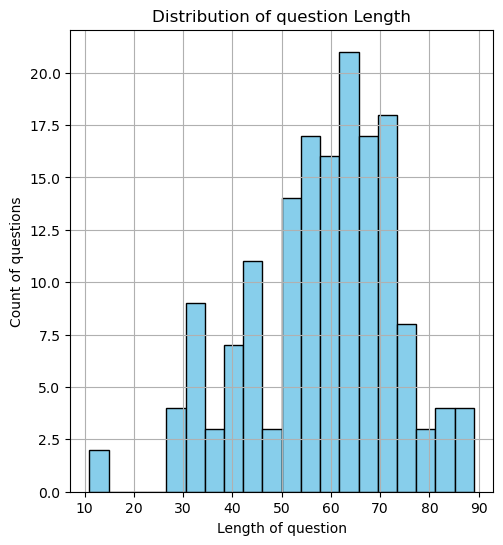

intent
book_flight      43
change_flight    41
cancel_flight    41
unknown          36
Name: count, dtype: int64


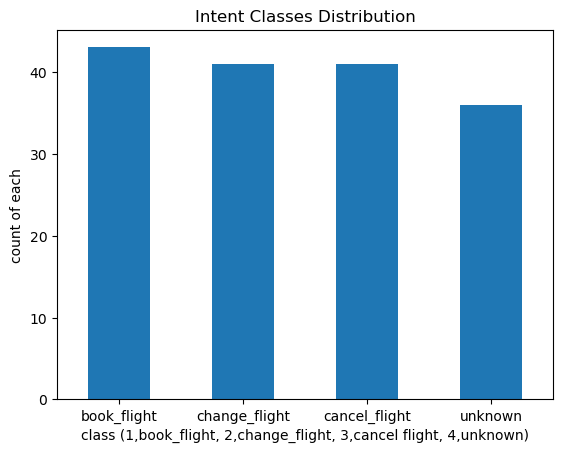

Total stop words in each row:
 0      4
1      4
2      6
3      6
4      3
      ..
156    4
157    4
158    0
159    0
160    3
Name: question, Length: 161, dtype: int64
Total words in each row:
 0       9
1      11
2      15
3      11
4       9
       ..
156     8
157     8
158     2
159     2
160     6
Name: question, Length: 161, dtype: int64
User: book flight
The entities the Chatbot found are:  []
Chatbot: Guy, where would you like to fly
User: London
The entities the Chatbot found are:  ['London (GPE)']
Chatbot: Guy, enter dates you want for your flight. Write only in this format: 'Monthname', 'year.' Example: January 1, 2023
User: january 1, 2022
The entities the Chatbot found are:  ['january 1, 2022 (DATE)']
Chatbot: Guy, Thank you, i have performed what you asked! Is there anything else i can help you with today?
User: change flight
The entities the Chatbot found are:  []
Chatbot: Guy, enter your new destination
User: berlin
The entities the Chatbot found are:  ['berlin (GPE

In [38]:
# downloading and importing required modules for the project
!pip install pandas
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacytextblob
!pip install matplotlib
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import csv
import spacy
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

# creating my question dataset
create_question_dataset()
df = read_chat_input_file('questions_for_model.csv')

#mapping classification and transforming target column
mapping = {'book_flight': 1, 'change_flight': 2, 'cancel_flight': 3, 'unknown': 4}
df['intent_ID'] = df['intent'].map(lambda x: mapping.get(x))

#performing tokenization on my csv file and training it
tokenized_df = tokenization(df)
model = training_model(tokenized_df)

#performing eda on the questions_for_model file to explore it
perform_eda('questions_for_model.csv')
# starting the online chatbot
run_online_chatbot()
# creating a new csv file with user input questions for offline mode
write_user_input_to_csv()
# starting the offline chatbot
print(run_offline_chatbot('user_questions.csv'))